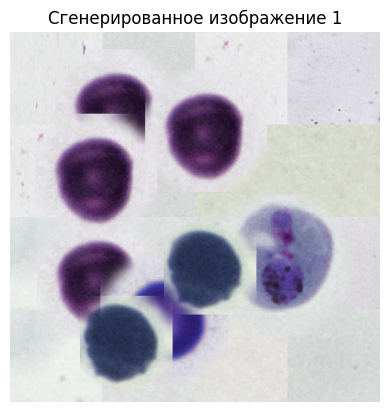

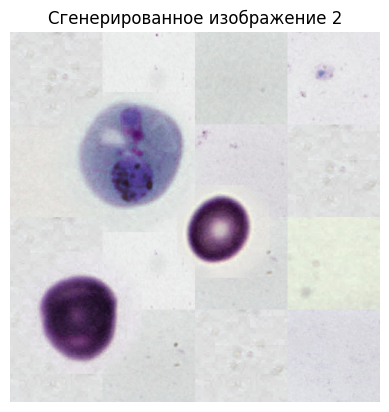

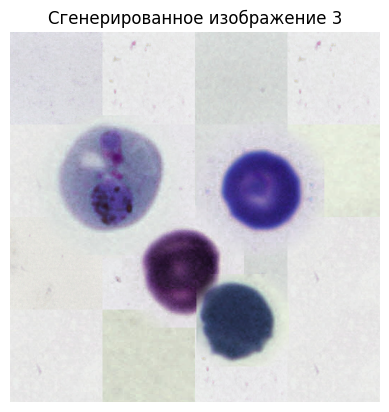

In [3]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

def load_patches_from_folder(folder_path):

    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background_from_patches(background_patches, num_patches=8, output_size=(256, 256)):

    # Случайно выбораем патчи (могут повторяться)
    selected_patches = random.choices(background_patches, k=num_patches)

    # создаём пустое изображение
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)

    patch_size = 128

    # добавляем патчи на фон
    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            if selected_patches:  # Если есть патчи для размещения
                patch = selected_patches.pop()

                # меняем размер при необходимости
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = cv2.resize(patch, (patch_size, patch_size))

                try:
                    background[i:i+patch_size, j:j+patch_size] = patch
                except ValueError as e:
                    print(f"Ошибка при размещении патча: {e}")
                    continue
            else:
                break

    return background

def overlay_cells_on_background(background, cell_patches, num_cells=5):

    output = background.copy()

    for _ in range(num_cells):

        cell = random.choice(cell_patches)

        x = random.randint(0, background.shape[0] - cell.shape[0])
        y = random.randint(0, background.shape[1] - cell.shape[1])

        mask = np.zeros((cell.shape[0], cell.shape[1], 3), dtype=np.uint8)
        radius = min(cell.shape[0], cell.shape[1]) // 2
        cv2.circle(mask, (cell.shape[1] // 2, cell.shape[0] // 2), radius, (255, 255, 255), -1)
        mask = cv2.GaussianBlur(mask, (51, 51), 0)

        mask = mask.astype(np.float32) / 255.0

        for c in range(3):
            output[x:x+cell.shape[0], y:y+cell.shape[1], c] = (
                output[x:x+cell.shape[0], y:y+cell.shape[1], c] * (1 - mask[:, :, c]) +
                cell[:, :, c] * mask[:, :, c]
            )

    return output

# Пути к папкам
patches_folder = '/content/patches'
background_folder = os.path.join(patches_folder, 'background')
cells_folder = os.path.join(patches_folder, 'cells')

background_patches = load_patches_from_folder(background_folder)
cell_patches = load_patches_from_folder(cells_folder)

# выведем три сгенерированнах изображения
for i in range(3):

    num_patches_for_background = 16
    background = generate_background_from_patches(background_patches, num_patches=num_patches_for_background, output_size=(512, 512))

    # Наложение клеток на фон
    num_cells = random.randint(3, 10)  # Случайное количество клеток
    final_image = overlay_cells_on_background(background, cell_patches, num_cells=num_cells)

    output_filename = f'generated_image_{i+1}.png'
    cv2.imwrite(output_filename, final_image)

    def show_image(image, title):
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

    show_image(final_image, f'Сгенерированное изображение {i+1}')